# Classification of Anomalies in Gastrointestinal Tract through Endoscopic Imagery with Deep Learning


### we used opencv for preproccesing the image dataset
### we used tensorflow and keras libarary for machine learning stuff 

In [42]:
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np
import tensorflow as tf
import tensorflowjs as tfjs
from tensorflow.keras import applications
from tensorflow.keras import optimizers
import argparse
from imutils import paths
import np_utils

### first we set the image dataset directory and define the categories 

In [17]:
datadir='/home/shashimal/Documents/dataset'
categories = ['dyed-lifted-polyps','dyed-resection-margins','esophagitis',
             'normal-cecum','normal-pylorus','normal-z-line','polyps','ulcerative-colitis']

### using the opencv, we read images from dataset directory and resize images to 96*96
### then insert the resized image with class lable to array

In [3]:
training_data=[]
def create_training_data():
    for category in categories:
        path = os.path.join(datadir,category)
        class_num = categories.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path,img))
                new_array = cv2.resize(img_array,(96,96))
#                crop_array = new_array[0:96,35:96]
                training_data.append([new_array,class_num])
            except Exception as e:    
                pass
create_training_data() 

###  append features and labels to separated list
### then convert the feature array into a NumPy array and reshape the array

In [69]:
x=[]
y=[]

for features,label in training_data:
    x.append(features)
    y.append(label)
x = np.array(x).reshape(8000,96,96,3)
x.shape

(8000, 96, 96, 3)

### partition the data into training and testing splits using 80% of the data for training and the remaining 20% for testing

In [70]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

### then preprocess dataset by scaling all pixel intensities to the range [0, 1]

In [71]:
x_train=x_train.astype('float32')
x_test=x_test.astype('float32')
x_train/=255
x_test/=255

### encode the labels (which are currently strings) as integers and then one-hot encode them

In [72]:
y_train = tf.keras.utils.to_categorical(y_train, 8)
y_test = tf.keras.utils.to_categorical(y_test, 8)

### import VGG19 model (for Transfer learning)

In [73]:
model = applications.VGG19(weights = "imagenet", include_top=False, input_shape = (96, 96, 3))


### first we iterate through the model and make 20 layer non-trainable
### then add pooling layer and add some dense layers with relu activation
### we used categorical_crossentropy loss function and Adam as the optimizer

In [80]:
for layer in model.layers[:20]:
    layer.trainable = False
x = model.output
x =  tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
predictions = tf.keras.layers.Dense(8, activation="softmax")(x)   
model_final = tf.keras.models.Model(model.input,predictions)
model_final.compile(loss="categorical_crossentropy", optimizer='Adam', metrics=["accuracy"])

    

### then we fit the dataset to train

In [82]:
history=model_final.fit(x_train, y_train,
          batch_size=32,
          epochs=8,
          verbose=1,
          validation_data=(x_test, y_test))

Train on 6400 samples, validate on 1600 samples
Epoch 1/8
6400/6400 [==============================] - 542s 85ms/sample - loss: 0.7060 - acc: 0.6850 - val_loss: 0.5868 - val_acc: 0.7563
Epoch 2/8
6400/6400 [==============================] - 533s 83ms/sample - loss: 0.5851 - acc: 0.7450 - val_loss: 0.5606 - val_acc: 0.7444
Epoch 3/8
6400/6400 [==============================] - 531s 83ms/sample - loss: 0.5352 - acc: 0.7783 - val_loss: 0.5574 - val_acc: 0.7744
Epoch 4/8
6400/6400 [==============================] - 530s 83ms/sample - loss: 0.4642 - acc: 0.8094 - val_loss: 0.4981 - val_acc: 0.7981
Epoch 5/8
6400/6400 [==============================] - 497s 78ms/sample - loss: 0.4255 - acc: 0.8236 - val_loss: 0.5117 - val_acc: 0.8112
Epoch 6/8
6400/6400 [==============================] - 491s 77ms/sample - loss: 0.3843 - acc: 0.8414 - val_loss: 0.5850 - val_acc: 0.7912
Epoch 7/8
6400/6400 [==============================] - 502s 78ms/sample - loss: 0.3606 - acc: 0.8562 - val_loss: 0.5147 - va

In [83]:
score = model_final.evaluate(x_test, y_test, verbose=0)

In [84]:
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.6057374227046967
Test accuracy: 0.80375


dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


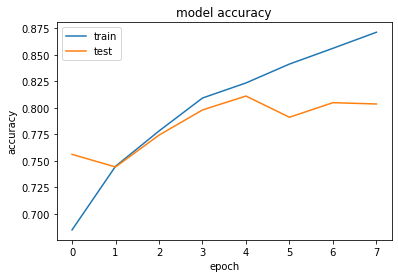

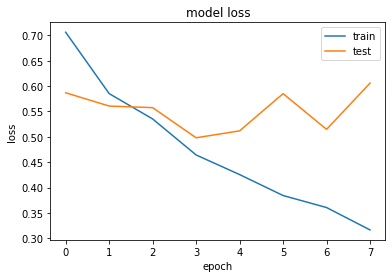

In [85]:
print(history.history.keys())

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

array([1.7406090e-01, 8.2465869e-01, 7.4679956e-05, 6.4581633e-05,
       3.0395921e-04, 3.3695229e-05, 7.4848841e-04, 5.4951608e-05],
      dtype=float32)

1

array([0., 1., 0., 0., 0., 0., 0., 0.], dtype=float32)